# test embeddings

plot tsne of the embeddings extracted by the CNN model trained on the dataset.

-> write a module for input generation. given the folder and file names get NxTxM matrix
-> each data point, load model in eval mode. 
-> forward the given 

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms as transforms
import sys
from ret_benchmark.config import cfg
from ret_benchmark.modeling import build_model
import os
import numpy as np
import re
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '1' # gpu to run the code
sys.path.insert(1, '/data/home/shruti/voxceleb/motion_signature/research-ms-loss-master/')
config_path = 'configs/ms_resnet50_vgg_ldr.yaml'
cache_emb_file = 'metric_ldr_emb_vgg' # this file is cache for vgg metric learning embeddings on leader data
#cache_emb_file = 'metric_ldr_emb' # this file is cache for fabnet metric learning embeddings on leader data

In [2]:
# get all the embedding
def load_obj(fldr, name ):
    if not os.path.exists(os.path.join(fldr, name + '.pkl')):
        return None
    with open(os.path.join(fldr, name + '.pkl'), 'rb') as f:
        return pickle.load(f)

# save the obj
def save_obj(obj, fldr, name ):
    os.makedirs(fldr, exist_ok=True)
    with open(os.path.join(fldr, name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## load model

In [3]:
def load_model(cfgpath):
    
    cfg.merge_from_file(cfgpath)
    
    # load the model
    model = build_model(cfg)
    device = torch.device(cfg.MODEL.DEVICE)
    model.to(device)
    model.eval()
    return model

In [4]:
model = load_model(config_path)

Resuming from model ...


## load data and labels

In [7]:
subfldrs = np.array(['bo_faceswap', 'bo_UWfake', 'diff_test', 'dt_faceswap', 'hc_faceswap', 'bs_faceswap',
                        'ew_faceswap'])

def get_ldrs_test_data():
        
    # read mean and std files
    means = np.reshape(np.load(cfg.INPUT.MEAN), (1, -1))
    stds = np.reshape(np.load(cfg.INPUT.STD), (1, -1))

    # the test files of leaders
    root = os.path.dirname(cfg.DATA.TEST_IMG_SOURCE)
    path_list = []
    label_list = []
    print(cfg.DATA.TEST_IMG_SOURCE)
    with open(cfg.DATA.TEST_IMG_SOURCE, 'r') as f:
        for line in f:
            _path, _label = re.split(r",| ", line.strip())
            path_list.extend([_path])
            label_list.extend([int(_label)])
    
    # add the files from 
    ofset = np.max(label_list) + 1
    for j in range(len(subfldrs)):
        _path = [os.path.join(subfldrs[j], f) for f in os.listdir(os.path.join(root, subfldrs[j])) if f.endswith('.npy')]
        _label = list(np.zeros((len(_path), ), dtype='int')+ofset+j)
        path_list.extend(_path)
        label_list.extend(_label)
    
    data = {}
    data['mean'] = means
    data['std'] = stds
    data['root'] = root
    data['path_list'] = path_list
    data['label_list'] = label_list
    
    return data


def get_ldrs_vgg_data():
        
    # read mean and std files
    means = np.reshape(np.load(cfg.INPUT.MEAN), (1, -1))
    stds = np.reshape(np.load(cfg.INPUT.STD), (1, -1))

    # the test files of leaders
    root = os.path.dirname(cfg.DATA.TEST_IMG_SOURCE)
    path_list = []
    label_list = []
    print(cfg.DATA.TEST_IMG_SOURCE)
    with open(cfg.DATA.TEST_IMG_SOURCE, 'r') as f:
        for line in f:
            _path, _label = re.split(r",| ", line.strip())
            path_list.extend([_path])
            label_list.extend([int(_label)])
    
    # add the files from 
    ofset = np.max(label_list) + 1
    for j in range(len(subfldrs)):
        _path = [f for f in os.listdir(root) if f.endswith('.npy') and f[:len(subfldrs[j])+1] == subfldrs[j]+'_']
        _label = list(np.zeros((len(_path), ), dtype='int')+ofset+j)
        path_list.extend(_path)
        label_list.extend(_label)
    
    data = {}
    data['mean'] = means
    data['std'] = stds
    data['root'] = root
    data['path_list'] = path_list
    data['label_list'] = label_list
    
    return data

In [8]:
#data_files = get_ldrs_test_data()
data_files = get_ldrs_vgg_data()

/data/home/shruti/voxceleb/vgg/leaders/leaders_150_test.txt


# get metric embedding

for every video file:
    1) load the npy
    2) for every 150 window with 5 frame step, pass it through the model and get the embedding
    3) in the save the embedding and the label in a dictionary
    4) save the embeddings 

In [11]:
def feature_extract(infile):
    
    st = 5; emb_sz = cfg.MODEL.HEAD.DIM
    fab_emb = np.load(infile)
    
    # if not enough time window
    if len(fab_emb)<cfg.INPUT.FRAME_LENGTH:
        return None
    
    if len(fab_emb.shape)>2:
        fab_emb = fab_emb[:, :, 0].copy()
    
    fab_emb = fab_emb/np.linalg.norm(fab_emb, axis=1, keepdims=True)
    fab_emb = (fab_emb-data_files['mean'])/data_files['std']
    
    feat_rng = np.arange(0, len(fab_emb)-cfg.INPUT.FRAME_LENGTH+1, st)
    out_feat = np.zeros((len(feat_rng), emb_sz))
    print(f' {out_feat.shape}')
    for i in range(len(feat_rng)):
        cur_data = fab_emb[feat_rng[i]:feat_rng[i]+cfg.INPUT.FRAME_LENGTH, :].copy()
        
        #transform
        cur_data = np.reshape(cur_data, (1, 1, cur_data.shape[0], cur_data.shape[1]))
        tensor_data = torch.from_numpy(cur_data).cuda().float()

        # pass the model
        with torch.no_grad():
            out_feat[i, :] = model(tensor_data).data.cpu().numpy().ravel()
    
    return out_feat


def raw_feature_extract(infile):
    fab_emb = np.load(infile)
    
    # if not enough time window
    if len(fab_emb)<cfg.INPUT.FRAME_LENGTH:
        return None
    
    if len(fab_emb.shape)>2:
        fab_emb = fab_emb[:, :, 0].copy()
    
    fab_emb = fab_emb/np.linalg.norm(fab_emb, axis=1, keepdims=True)
    fab_emb = (fab_emb-data_files['mean'])/data_files['std']
    
    return fab_emb

In [12]:
int2str_lbl = {0:'bo', 1:'br', 2:'bs', 3:'cb', 4:'dt_week', 4:'dt_rndm', 5:'ew', 6:'hc', 7:'jb', 8:'kh', 9:'pb', 
               10:'bo_faceswap', 11:'bo_UWfake', 12:'diff_test', 13:'dt_faceswap', 14:'hc_faceswap', 15:'bs_faceswap',
               16:'ew_faceswap'}

# for every embedding file
data_dict = load_obj( 'obj', 'metric_ldr_emb_vgg' )
if data_dict is None:
    
    data_dict = {}
    for i in range(len(data_files['path_list'])): #
        
        print(data_files['path_list'][i], end=' ')
        # 
        if int2str_lbl[data_files['label_list'][i]] not in data_dict.keys():
            data_dict[int2str_lbl[data_files['label_list'][i]]] = []
            
        cur_feat = feature_extract(os.path.join(data_files['root'], data_files['path_list'][i]))
        if cur_feat is not None:
            data_dict[int2str_lbl[data_files['label_list'][i]]].append(cur_feat)
    
    for i, (k, v) in enumerate(int2str_lbl.items()):
        data_dict[v] = np.vstack(data_dict[v])
    
    save_obj(data_dict, 'obj', 'metric_ldr_emb_vgg' )

bo_u2ZydUXdLUo_2.npy  (321, 512)
bo_u2ZydUXdLUo_3.npy  (237, 512)
bo_u35CyK7m1l8_0.npy  (287, 512)
bo_u35CyK7m1l8_1.npy  (319, 512)
bo_u35CyK7m1l8_2.npy  (317, 512)
bo_u35CyK7m1l8_3.npy  (315, 512)
bo_u35CyK7m1l8_4.npy  (199, 512)
bo_u4imJdOtTC0_0.npy  (263, 512)
bo_u4imJdOtTC0_1.npy  (321, 512)
bo_u4imJdOtTC0_2.npy  (296, 512)
bo_uBWl6QglKFU_0.npy  (283, 512)
bo_uBWl6QglKFU_1.npy  (311, 512)
bo_uBWl6QglKFU_2.npy  (321, 512)
bo_uBWl6QglKFU_3.npy  (283, 512)
bo_uCrCujWIgUY_0.npy  (287, 512)
bo_uCrCujWIgUY_1.npy  (320, 512)
bo_uCrCujWIgUY_2.npy  (321, 512)
bo_uRxHq9nLNto_0.npy  (285, 512)
bo_uRxHq9nLNto_1.npy  (321, 512)
bo_uRxHq9nLNto_2.npy  (317, 512)
bo_uRxHq9nLNto_3.npy  (320, 512)
bo_uRxHq9nLNto_4.npy  (314, 512)
bo_uW-oUy3kDhA_0.npy  (286, 512)
bo_uW-oUy3kDhA_1.npy  (321, 512)
bo_uW-oUy3kDhA_2.npy  (321, 512)
bo_uW-oUy3kDhA_3.npy  (320, 512)
bo_ubWStqYqn7s_0.npy  (260, 512)
bo_ubWStqYqn7s_1.npy  (316, 512)
bo_ubWStqYqn7s_2.npy  (163, 512)
bo_umXgNpiPzxs_0.npy  (262, 512)
bo_umXgNpi

dt_rndm_ejAp8q3yzt0_0.npy  (112, 512)
dt_rndm_i5Iuq8psx4o_0.npy  (82, 512)
dt_rndm_i5Iuq8psx4o_1.npy  (66, 512)
dt_rndm_i5Iuq8psx4o_11.npy  (113, 512)
dt_rndm_i5Iuq8psx4o_12.npy  (120, 512)
dt_rndm_i5Iuq8psx4o_2.npy  (83, 512)
dt_rndm_i5Iuq8psx4o_3.npy  (130, 512)
dt_rndm_i5Iuq8psx4o_4.npy  (91, 512)
dt_rndm_i5Iuq8psx4o_5.npy  (101, 512)
dt_rndm_i5Iuq8psx4o_7.npy  (69, 512)
dt_rndm_i5Iuq8psx4o_9.npy  (87, 512)
dt_rndm_kcuQI0V_g-Y_0.npy  (55, 512)
dt_rndm_kcuQI0V_g-Y_1.npy  (73, 512)
dt_rndm_kcuQI0V_g-Y_2.npy  (68, 512)
dt_rndm_kcuQI0V_g-Y_3.npy  (95, 512)
dt_rndm_kcuQI0V_g-Y_4.npy  (55, 512)
dt_rndm_kcuQI0V_g-Y_5.npy  (101, 512)
dt_rndm_kcuQI0V_g-Y_6.npy  (70, 512)
dt_rndm_kcuQI0V_g-Y_7.npy  (66, 512)
dt_rndm_ye0Xblp_Nb0_0_0.npy  (208, 512)
dt_rndm_ye0Xblp_Nb0_0_1.npy  (208, 512)
ew_tVAFzqI5qX4_8.npy  (101, 512)
ew_tzI1k7eEc9Q_1.npy  (165, 512)
ew_tzI1k7eEc9Q_10.npy  (112, 512)
ew_tzI1k7eEc9Q_11.npy  (85, 512)
ew_tzI1k7eEc9Q_14.npy  (74, 512)
ew_tzI1k7eEc9Q_15.npy  (172, 512)
ew_tzI1k7

bo_UWfake_debug_cNVzN62l0Yg}}00_3vPdtajOJfw_refined_0.npy  (172, 512)
bo_UWfake_debug_7G5kMmnAp_8}}00_25GOnaY8ZCY_0.npy  (196, 512)
bo_UWfake_debug_Hdn1iX1a528}}01_25GOnaY8ZCY_0.npy  (196, 512)
bo_UWfake_debug_ten}}00_3vPdtajOJfw_0.npy  (58, 512)
bo_UWfake_debug_nIxM8rL5GVE}}03_k4OZOTaf3lk_1.npy  (227, 512)
bo_UWfake_debug_nIxM8rL5GVE}}00_3vPdtajOJfw_mul1_0.npy  (191, 512)
bo_UWfake_Obama_fake_uw_10data_0.npy  (37, 512)
bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_data60_1.npy  (190, 512)
bo_UWfake_debug__iKNE4ndBdg}}00_25GOnaY8ZCY_0.npy  (292, 512)
bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_bestyet_1.npy  (190, 512)
bo_UWfake_debug_F8MxP9adPO8}}02_3vPdtajOJfw_0.npy  (136, 512)
bo_UWfake_debug_stitched-audioclip_final2}}00_3vPdtajOJfw_0.npy  (214, 512)
bo_UWfake_debug_nIxM8rL5GVE}}00_3vPdtajOJfw_1.npy  (190, 512)
bo_UWfake_debug_ten3}}00_3vPdtajOJfw_0.npy  (58, 512)
bo_UWfake_Obama_fake_uw_2.npy  (325, 512)
bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_035_1.npy  (190, 512)
bo_UWfake_deb

diff_test_-2Zdu3hMGVw.npy  (104, 512)
diff_test_v-ZKI-eqKtg.npy  (62, 512)
diff_test_ugyYHAxIMrc.npy  (94, 512)
diff_test_6W7kF_F0G90.npy  (68, 512)
diff_test_agwQVsr_Krs.npy  (85, 512)
diff_test_pGmDKODT6V4.npy  (55, 512)
diff_test_8AEye_DhrLE.npy  (65, 512)
diff_test_mjnMO3Rd54g.npy  (241, 512)
diff_test_Pm2rw9hSmm4.npy  (54, 512)
diff_test_Yaxc9nAvOD4.npy  (63, 512)
diff_test_v_MP513a0v8.npy  (76, 512)
diff_test_KqSl5C8Zlfc.npy  (89, 512)
diff_test_pbD-H8KisWY.npy  (179, 512)
diff_test_JNt0nChuZ24.npy  (157, 512)
diff_test_pbuuZv60C4Q.npy  (85, 512)
diff_test_xffuIgiRUZw.npy  (56, 512)
diff_test_FTwDVMUysfk.npy  (67, 512)
diff_test_oaUa1v_-HtE.npy  (96, 512)
diff_test_p9KWUF4GY9w.npy  (134, 512)
diff_test_EQhLO7NZmZk.npy  (68, 512)
diff_test_ySy2dIJ889c.npy  (65, 512)
diff_test_r7B491zbxnw.npy  (60, 512)
diff_test_3DH8E9oNxEs.npy  (72, 512)
diff_test_d0r7XunetJw.npy  (86, 512)
diff_test_FtaRM4aj3AE.npy  (69, 512)
diff_test_ILDc0AwH5A0.npy  (93, 512)
diff_test_sj487ZTSkN8.npy  (53, 5

hc_faceswap_24_output.npy  (268, 512)
hc_faceswap_06_output.npy  (130, 512)
hc_faceswap_18_output_1.npy  (259, 512)
hc_faceswap_09_output.npy  (52, 512)
hc_faceswap_01_output.npy  (112, 512)
hc_faceswap_10_output.npy  (64, 512)
hc_faceswap_05_output.npy  (64, 512)
hc_faceswap_23_output.npy  (172, 512)
hc_faceswap_14_output.npy  (130, 512)
hc_faceswap_21_output.npy  (154, 512)
hc_faceswap_03_output.npy  (70, 512)
hc_faceswap_12_output.npy  (100, 512)
hc_faceswap_25_output.npy  (52, 512)
hc_faceswap_07_output.npy  (100, 512)
hc_faceswap_16_output.npy  (124, 512)
bs_faceswap_02_output.npy  (280, 512)
bs_faceswap_03_output_0.npy  (258, 512)
bs_faceswap_04_output.npy  (109, 512)
bs_faceswap_03_output_2.npy  (258, 512)
bs_faceswap_03_output_1.npy  (258, 512)
bs_faceswap_01_output.npy  (73, 512)
bs_faceswap_05_output.npy  (94, 512)
ew_faceswap_07_output.npy  (42, 512)
ew_faceswap_03_output.npy  (178, 512)
ew_faceswap_09_output.npy  (63, 512)
ew_faceswap_10_output.npy  (47, 512)
ew_faceswap_01

In [22]:
# for every embedding file
raw_dict = load_obj( 'obj', 'raw_ldr_emb_vgg' )
if raw_dict is None:
    
    raw_dict = {}
    for i in range(len(data_files['path_list'])): #
        
        print(data_files['path_list'][i], end=' ')
        # 
        if int2str_lbl[data_files['label_list'][i]] not in raw_dict.keys():
            raw_dict[int2str_lbl[data_files['label_list'][i]]] = []
            
        cur_feat = raw_feature_extract(os.path.join(data_files['root'], data_files['path_list'][i]))
        if cur_feat is not None:
            raw_dict[int2str_lbl[data_files['label_list'][i]]].append(cur_feat)
    
    for i, (k, v) in enumerate(int2str_lbl.items()):
        raw_dict[v] = np.vstack(raw_dict[v])
    
    save_obj(raw_dict, 'obj', 'raw_ldr_emb_vgg' )

bo_u2ZydUXdLUo_2.npy bo_u2ZydUXdLUo_3.npy bo_u35CyK7m1l8_0.npy bo_u35CyK7m1l8_1.npy bo_u35CyK7m1l8_2.npy bo_u35CyK7m1l8_3.npy bo_u35CyK7m1l8_4.npy bo_u4imJdOtTC0_0.npy bo_u4imJdOtTC0_1.npy bo_u4imJdOtTC0_2.npy bo_uBWl6QglKFU_0.npy bo_uBWl6QglKFU_1.npy bo_uBWl6QglKFU_2.npy bo_uBWl6QglKFU_3.npy bo_uCrCujWIgUY_0.npy bo_uCrCujWIgUY_1.npy bo_uCrCujWIgUY_2.npy bo_uRxHq9nLNto_0.npy bo_uRxHq9nLNto_1.npy bo_uRxHq9nLNto_2.npy bo_uRxHq9nLNto_3.npy bo_uRxHq9nLNto_4.npy bo_uW-oUy3kDhA_0.npy bo_uW-oUy3kDhA_1.npy bo_uW-oUy3kDhA_2.npy bo_uW-oUy3kDhA_3.npy bo_ubWStqYqn7s_0.npy bo_ubWStqYqn7s_1.npy bo_ubWStqYqn7s_2.npy bo_umXgNpiPzxs_0.npy bo_umXgNpiPzxs_1.npy bo_umXgNpiPzxs_2.npy bo_umXgNpiPzxs_3.npy bo_uwoXppkTnng_0.npy bo_uwoXppkTnng_1.npy bo_uwoXppkTnng_2.npy bo_uwoXppkTnng_3.npy bo_uwoXppkTnng_4.npy bo_vIiZOTCwhNY_0.npy bo_vIiZOTCwhNY_1.npy bo_vIiZOTCwhNY_2.npy bo_vIiZOTCwhNY_3.npy bo_vIiZOTCwhNY_4.npy bo_vQyllaM6dro_0.npy bo_vQyllaM6dro_1.npy bo_vQyllaM6dro_2.npy bo_vQyllaM6dro_3.npy bo_vQyllaM6dr

pb_qHZAYve8f-I_7_0.npy pb_qHZAYve8f-I_9_0.npy pb_qHZAYve8f-I_9_1.npy pb_yxH30Nx17H4_11_0.npy pb_yxH30Nx17H4_12_0.npy pb_yxH30Nx17H4_2_0.npy pb_yxH30Nx17H4_3_0.npy pb_yxH30Nx17H4_4_0.npy pb_yxH30Nx17H4_5_0.npy pb_yxH30Nx17H4_6_0.npy pb_yxH30Nx17H4_7_0.npy bo_faceswap_02_output.npy bo_faceswap_11_output.npy bo_faceswap_13_output.npy bo_faceswap_08_output.npy bo_faceswap_12_output.npy bo_faceswap_03_output.npy bo_faceswap_07_output.npy bo_faceswap_14_output.npy bo_faceswap_05_output.npy bo_faceswap_09_output.npy bo_faceswap_01_output.npy bo_faceswap_10_output.npy bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_bestyet_0.npy bo_UWfake_debug_F8MxP9adPO8}}01_3vPdtajOJfw_0.npy bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_data60_0.npy bo_UWfake_debug_F8MxP9adPO8}}00_25GOnaY8ZCY_0.npy bo_UWfake_debug_nIxM8rL5GVE}}00_3vPdtajOJfw_unrefined_1.npy bo_UWfake_debug_nIxM8rL5GVE}}00_25GOnaY8ZCY_data50_1.npy bo_UWfake_debug__iKNE4ndBdg}}00_25GOnaY8ZCY__0.npy bo_UWfake_debug_nIxM8rL5GVE}}00_3vPdtajOJfw_0.npy 

diff_test_wOBTdvyWWNk.npy diff_test_CRluQ54RAFM.npy diff_test_BP52hP0TLU0.npy diff_test_CFlVYLX4fQs.npy diff_test_WxJH6RBAXqA.npy diff_test_kOil2HSDq0E.npy diff_test_wpjqfn8Cxm0.npy diff_test_hncv-bDkrPw.npy diff_test_vV_h9VUykDg.npy diff_test_2lSQaOzVONg.npy diff_test_E9WhvBtLXvs.npy diff_test_hSm06cTG1TE.npy diff_test_mMeDsvxz5BA.npy diff_test_ELdJy9NhUgc.npy diff_test_uENBtxJ1FnA.npy diff_test_VyrhRXZ901o.npy diff_test_wiQB_pv68cU.npy diff_test_Fg4hl4bmObU.npy diff_test_XTpKPHgjBYs.npy diff_test_FaQVnnWu4Yk.npy diff_test_iX6eJ38E3Rs.npy diff_test_ZK-9QZyQabk.npy diff_test_ydWES3m6QrY.npy diff_test_nGHhg-gj7PM.npy diff_test_Xgor7M--cI4.npy diff_test_ALW9IXRMi1g.npy diff_test_Fshh4w2zEbg.npy diff_test_rI7GbgEhwoY.npy diff_test_DjwudZqo-Bg.npy diff_test_Ctexu_Rf_2M.npy diff_test_Fm96-nebe-8.npy diff_test_xG9J__APvnY.npy diff_test_KmNaFaybc7k.npy diff_test_x4dffEgdvwU.npy diff_test_q9J9OROAF3w.npy diff_test_1sdTxz94FFw.npy diff_test_-2Zdu3hMGVw.npy diff_test_v-ZKI-eqKtg.npy diff_test_ug

## TSNE

In [14]:
rs = 777
np.random.seed(rs)
obj_bsfldr = 'obj/'

# train: randm and diff
# test: obama and fake
def get_dataset(dataset):

    X_test = None
    y_test = None
    i = 0
    all_keys = list(dataset.keys())
    all_keys = np.sort(all_keys)
    for k in all_keys:
        f_arr = dataset[k].copy()
        np.random.seed(0)
        idx = np.random.choice(range(len(f_arr)), size=np.min([1000, len(f_arr)]), replace=False)
        if X_test is None:
            X_test = f_arr[idx, :].copy()
            y_test = np.zeros((len(X_test), ))
        else:
            X_test = np.concatenate((X_test, f_arr[idx, :]), axis=0)
            y_test = np.concatenate((y_test, np.zeros((len(f_arr[idx, :]), ))+i), axis=0)

        i = i+1
    return X_test, y_test

def remove_keys(cur_dict):
    cur_dict.pop('__header__', None)
    cur_dict.pop('__version__', None)
    cur_dict.pop('__globals__', None)
    return cur_dict

In [15]:
#this one combination result
def one_setting_train(dataset, title):

    #get datasets
    X_test, y_test = get_dataset(dataset)
    tsne = TSNE(n_components=2, perplexity=30.0,
                         early_exaggeration=12.0, learning_rate=200.0,
                         n_iter=1000, n_iter_without_progress=300,
                         min_grad_norm=1e-07, metric='euclidean',
                         init='random', verbose=0, random_state=rs,
                         method='barnes_hut', angle=0.5)
    print('tsne train {}'.format(X_test.shape))
    Y = tsne.fit_transform(X_test)

    all_keys = list(dataset.keys())
    all_keys = np.sort(all_keys)

    colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1, len(all_keys))]

    fig, ax = plt.subplots(figsize=(8, 8))
    for k in range(len(all_keys)):
        plt.scatter(Y[y_test==k, 0], Y[y_test==k, 1],
                    label=r'{}'.format(all_keys[k]), alpha=0.7, facecolors=colorst[k])

    plt.legend(prop={'size': 8}, loc='upper right')
    plt.xticks([])
    plt.yticks([])
    ax.axis('off')
    plt.tight_layout(pad=-2, h_pad=None, w_pad=None, rect=None)
    plt.draw()
    plt.savefig(title)
    plt.show()

# plot tSNE

### FAbnet Metric Embedding

tsne train (16572, 256)


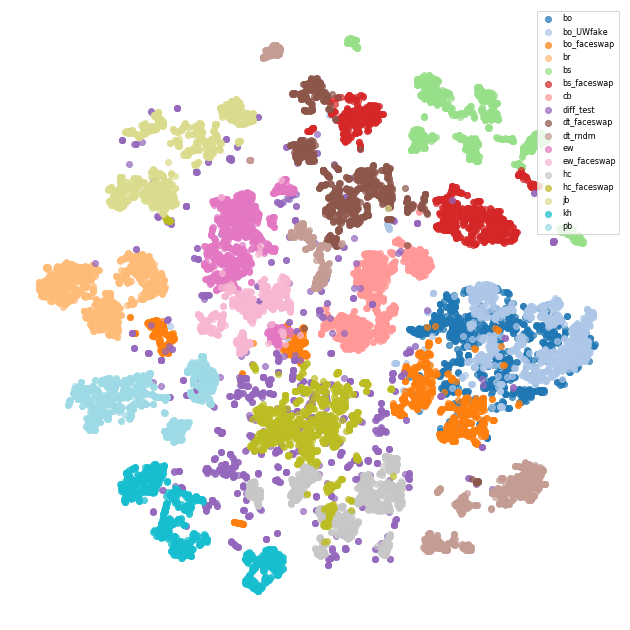

In [17]:
fabNet_metric = load_obj( 'obj', 'metric_ldr_emb' )
one_setting_train(fabNet_metric, 'fabnet_metric.png')

### FAbnet Raw Embedding

tsne train (17000, 256)


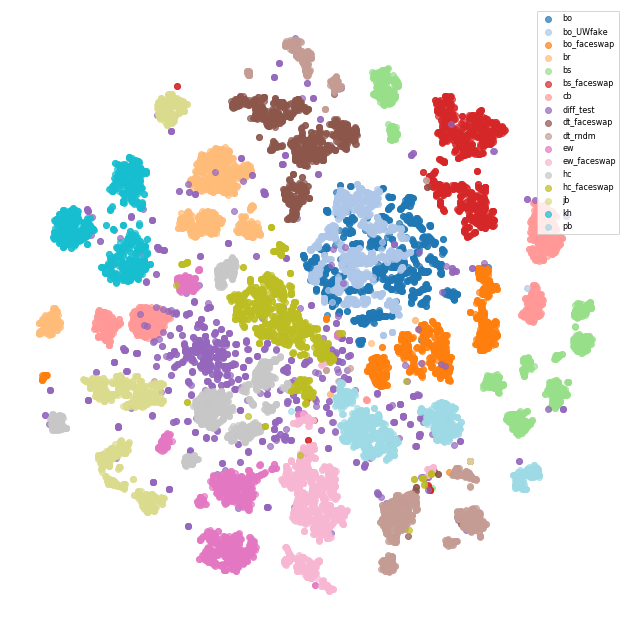

In [21]:
fabNet_raw = load_obj( 'obj', 'raw_ldr_emb' )
one_setting_train(fabNet_raw, 'fabnet_raw.png')

### VGG Metric Embedding

tsne train (16782, 512)


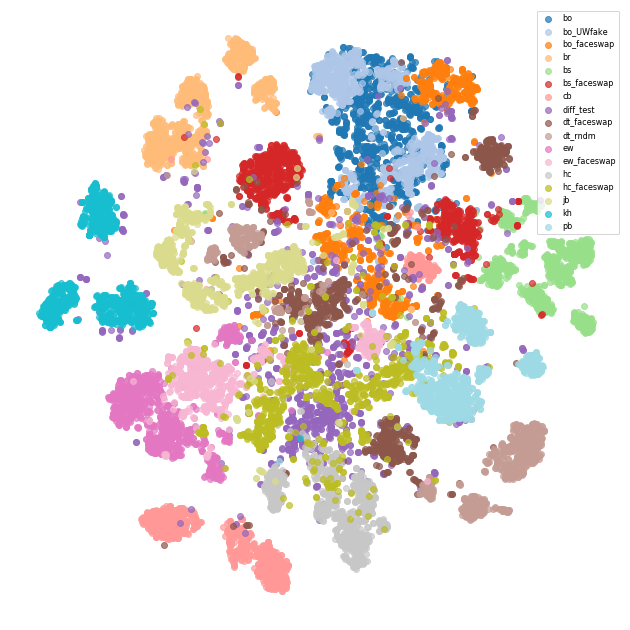

In [19]:
vgg_metric = load_obj( 'obj', 'metric_ldr_emb_vgg' )
one_setting_train(vgg_metric, 'vgg_metric.png')

### VGG Raw Embedding

tsne train (17000, 4096)


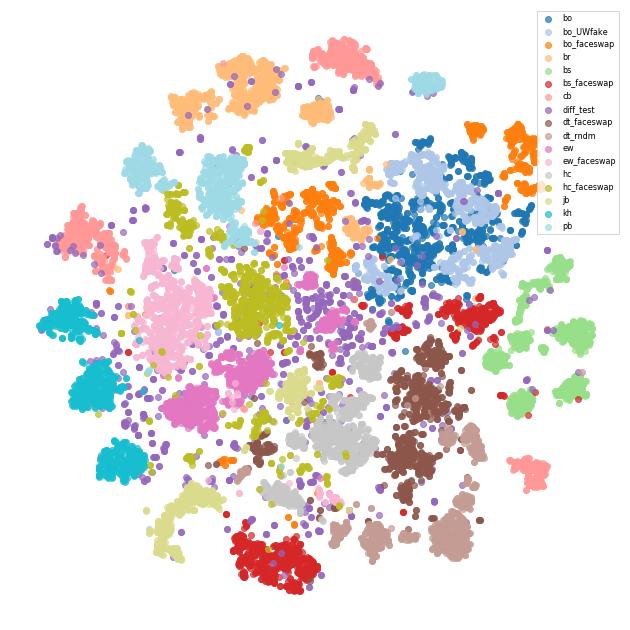

In [23]:
vgg_raw = load_obj( 'obj', 'raw_ldr_emb_vgg' )
one_setting_train(vgg_raw, 'vgg_raw.png')